<a href="https://colab.research.google.com/github/kathmandu777/Img-and-Video-check/blob/main/GenTwo_imgcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenTwoの投稿画像検証
- GenTwoにおいて、投稿された画像が不適切かどうかを判断します。

## 設計
1. 投稿画像の受け取り
2. 画像認識
  - YOLO（性能と速度によっては変更）
3. 認識物がNGリストに載っていればリジェクト
  - 何がリジェクトされたか、ユーザーが分かるようにバウンディングボックスの描画


## 画像NGリスト
- undefined

## 参考文献
- [markdown記法](https://qiita.com/tbpgr/items/989c6badefff69377da7#%E5%BC%95%E7%94%A8)
- [TensorFlow Hub ?](https://qiita.com/code0327/items/3b23fd5002b373dc8ae8)

In [1]:
# 環境変数を追加
# 検出器のモジュールを格納するフォルダの設定
import os
os.environ['TFHUB_CACHE_DIR'] ='/content/tfhub'

# 環境変数の確認
!printenv TFHUB_CACHE_DIR

# TensorFlow2.xに切り替え
%tensorflow_version 2.x

/content/tfhub


In [2]:
# 検出器のロード
import tensorflow as tf
import tensorflow_hub as hub

module_handle = 'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'
#module_handle = 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
# 検出結果を画像にオーバーレイ表示
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe 

def showImage(img, r, min_score=0.1):
  fig = plt.figure(dpi=150,figsize=(8,8))
  ax = plt.gca()
  ax.tick_params(axis='both', which='both', left=False, 
                 labelleft=False, bottom=False, labelbottom=False)
  ax.imshow(img)

  decode = np.frompyfunc( lambda p : p.decode("ascii"), 1, 1)

  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  class_names = decode( r['detection_class_entities'] )

  n = np.count_nonzero(scores >= min_score)

  # class_names に対応した 色の準備
  class_set = np.unique(class_names[:n])
  colors = dict()
  cmap = plt.get_cmap('tab10')
  for i, v in enumerate(class_set):
    colors[v] =cmap(i)

  # 矩形を描画 スコアが低いものから描画
  img_w = img.shape[1]
  img_h = img.shape[0]
  for i in reversed(range(n)):
    text = f'{class_names[i]} {100*scores[i]:.0f}%'
    color = colors[class_names[i]]
    y1, x1, y2, x2 = tuple(boxes[i])
    y1, y2 = y1*img_h, y2*img_h
    x1, x2 = x1*img_w, x2*img_w

    # 枠
    r = plt.Rectangle(xy=(x1, y1), width=(x2-x1), height=(y2-y1),
                      fill=False, edgecolor=color, joinstyle='round', 
                      clip_on=False, zorder=8+(n-i) )
    ax.add_patch( r )

    # タグ：テキスト
    t = ax.text(x1+img_w/200, y1-img_h/300, text, va='bottom', fontsize=6, color=color,zorder=8+(n-i))
    t.set_path_effects([pe.Stroke(linewidth=1.5,foreground='white'), pe.Normal()])
    fig.canvas.draw()
    r = fig.canvas.get_renderer()
    coords = ax.transData.inverted().transform(t.get_window_extent(renderer=r))
    tag_w = abs(coords[0,0]-coords[1,0])+img_w/100
    tag_h = abs(coords[0,1]-coords[1,1])+img_h/120

    # タグ：背景
    r = plt.Rectangle(xy=(x1, y1-tag_h), width=tag_w, height=tag_h,
                      edgecolor=color, facecolor=color,
                      joinstyle='round', clip_on=False, zorder=8+(n-i))
    ax.add_patch(r)

In [4]:
# 物体検出を実行する関数定義
import time
import numpy as np
import PIL.Image as Image

def run_detector(detector, path):

  # 画像を読み込んで detector に入力できる形式に変換
  img = Image.open(path) # Pillow(PIL)
  if img.mode == 'RGBA' :
    img = img.convert('RGB')
  converted_img = img.copy()
  converted_img = converted_img.resize((227,227),Image.LANCZOS) # 入力サイズに縮小
  converted_img = np.array(converted_img, dtype=np.float32)     # np.arrayに変換
  converted_img = converted_img / 255. # 0.0 ～ 1.0 に正規化
  converted_img = converted_img.reshape([1,227,227,3])
  converted_img = tf.constant(converted_img)

  t1 = time.time()
  result = detector(converted_img) # 一般物体検出（本体）
  t2 = time.time()
  print(f'検出時間 : {t2-t1:.3f} 秒' )

  # 結果をテキスト出力するための準備
  r = {key:value.numpy() for key,value in result.items()}
  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  decode = np.frompyfunc( lambda p : p.decode('ascii'), 1, 1)
  class_names = decode( r['detection_class_entities'] )

  # スコアが 0.25 以上の結果（n件）についてテキスト出力 
  print(f'検出オブジェクト' )
  n = np.count_nonzero(scores >= 0.25 )
  for i in range(n):
    y1, x1, y2, x2 = tuple(boxes[i])
    x1, x2 = int(x1*img.width), int(x2*img.width)
    y1, y2 = int(y1*img.height),int(y2*img.height)
    t = f'{class_names[i]:10} {100*scores[i]:3.0f}%  '
    t += f'({x1:>4},{y1:>4}) - ({x2:>4},{y2:>4})'
    print(t)

  showImage(np.array(img), r, min_score=0.25) # 検出結果を画像にオーバーレイ


物体検出したい画像を選択してください(複数選択可)


Saving 002.jpg to 002.jpg
検出時間 : 8.023 秒
検出オブジェクト
Human face  94%  ( 900, 152) - (1455, 762)
Girl        36%  ( 142,   0) - (1809,1061)

物体検出を続けますか?(Y or n) n
終了


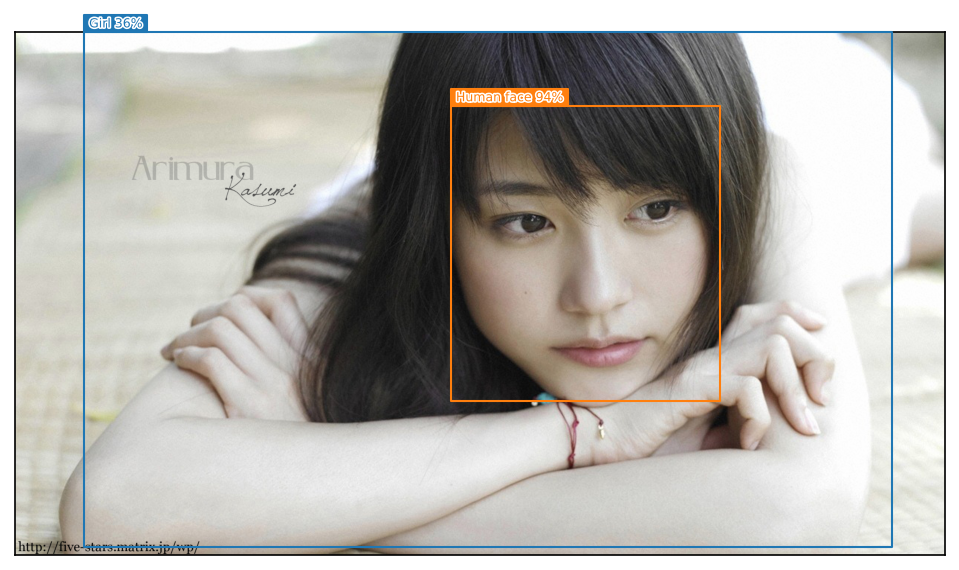

In [6]:
# 物体検出
from google.colab import files

isContinue=True

while(isContinue):
  print("\n物体検出したい画像を選択してください(複数選択可)")
  uploaded = files.upload()#分類したい画像を選択
    
  for fn in uploaded.keys():
    run_detector(detector, fn)
  print("\n物体検出を続けますか?(Y or n)",end=" ")
  isContinue = False if input()=="n" else True   # nだったら終了(nに重みを置いている)
print("終了")